# Assignment 1 - Steady-State Conduction

#Solve each of the following problems and explain your results. For each problem, determine an appropriate number of control volumes through a grid independence study. Determine the number of iterations required for convergence and comment on the result.

## Problem 1 - Linear Heat Conduction

Solve for the one-dimensional temperature distribution in a square bar of mild steel as given below. The properties of mild steel are:

 - $k$ = 60 [W/m$\cdot$K]
 - $\rho$ = 7800 [kg/m$^3$]
 - $c_p$ = 430 [J/kg$\cdot$K]
 
Assume the convection coefficient is zero on the exposed surfaces, and fixed end temperatures of $T_1$ =100 [$^\circ$C] and $T_2$ = 0 [$^\circ$C].

![SquareBar](Figures/1-SquareBar.png)

In [2]:
## CLASSES DEFINED TO BE USED IN ALL THE PROBLEMS of this assignment

##Grid definition

import numpy as np

class Grid:
    """Class defining a one-dimensional Cartesian grid"""
    
    def __init__(self, lx, ly, lz, ncv):
        """Constructor
            lx .... total length of domain in x-direction [m]
            ly .... total length of domain in y-direction [m]
            lz .... total length of domain in z-direction [m]
            ncv ... number of control volumes in domain
        """
        # Store the number of control volumes
        self._ncv = ncv
        
        # Calculate the control volume length
        dx = lx/float(ncv)
        
        # Calculate the face locations
        self._xf = np.array([i*dx for i in range(ncv+1)])
        
        # Calculate the cell centroid locations
        self._xP = np.array([self._xf[0]] + 
                            [0.5*(self._xf[i]+self._xf[i+1]) for i in range(ncv)] +
                            [self._xf[-1]])
        
        # Calculate face areas
        self._Af = ly*lz*np.ones(ncv+1)
        
        # Calculate the outer surface area for each cell
        self._Ao = (2.0*dx*ly + 2.0*dx*lz)*np.ones(ncv)
        
        # Calculate cell volumes
        self._vol = dx*ly*lz*np.ones(ncv)
        
    @property
    def ncv(self):
        """Number of control volumes in domain"""
        return self._ncv
    
    @property
    def xf(self):
        """Face location array"""
        return self._xf
    
    @property
    def xP(self):
        """Cell centroid array"""
        return self._xP
    
    @property
    def dx_WP(self):
        return self.xP[1:-1]-self.xP[0:-2]
        
    @property
    def dx_PE(self):
        return self.xP[2:]-self.xP[1:-1]
      
    @property
    def Af(self):
        """Face area array"""
        return self._Af

    @property
    def Aw(self):
        """West face area array"""
        return self._Af[0:-1]
    
    @property
    def Ae(self):
        """East face area array"""
        return self._Af[1:]
    
    @property
    def Ao(self):
        """Outer face area array"""
        return self._Ao
    
    @property
    def vol(self):
        """Cell volume array"""
        return self._vol

In [3]:
class ScalarCoeffs:
    """Class defining the set of coefficients for a finite-volume discretization
       of a scalar partial differential equation.
    """
    
    def __init__(self, ncv):
        """Constructor
            ncv ... number of control volumes in domain
        """
        self._ncv = ncv
        self._aP = np.zeros(ncv)
        self._aW = np.zeros(ncv)
        self._aE = np.zeros(ncv)
        self._rP = np.zeros(ncv)
        
    def zero(self):
        """Function to zero the coefficient arrays"""
        self._aP.fill(0.0)
        self._aW.fill(0.0)
        self._aE.fill(0.0)
        self._rP.fill(0.0)
        
    def accumulate_aP(self, aP):
        """Function to accumulate values onto aP"""
        self._aP += aP
        
    def accumulate_aW(self, aW):
        """Function to accumulate values onto aW"""
        self._aW += aW

    def accumulate_aE(self, aE):
        """Function to accumulate values onto aE"""
        self._aE += aE
        
    def accumulate_rP(self, rP):
        """Function to accumulate values onto rP"""
        self._rP += rP
        
    @property
    def ncv(self):
        """Number of control volumes in domain"""
        return self._ncv
        
    @property
    def aP(self):
        """Cell coefficient"""
        return self._aP
    
    @property
    def aW(self):
        """West cell coefficient"""
        return self._aW
    
    @property
    def aE(self):
        """East cell coefficient"""
        return self._aE
    
    @property
    def rP(self):
        """Cell residual"""
        return self._rP

In [4]:
from enum import Enum

class BoundaryLocation(Enum):
    """Enumeration class defining boundary condition locations"""
    WEST = 1
    EAST = 2
    

In [5]:
class DirichletBc:
    """Class defining a Dirichlet boundary condition"""
    
    def __init__(self, phi, grid, value, loc):
        """Constructor
            phi ..... field variable array
            grid .... grid
            value ... boundary value
            loc ..... boundary location
        """
        self._phi = phi
        self._grid = grid
        self._value = value
        self._loc = loc
        
    def value(self):
        """Return the boundary condition value"""
        return self._value
    
    def coeff(self):
        """Return the linearization coefficient"""
        return 0
    
    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = self._value
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = self._value
        else:
            raise ValueError("Unknown boundary location")

In [6]:
class DiffusionModel:
    """Class defining a diffusion model"""
    
    def __init__(self, grid, phi, gamma, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._gamma = gamma
        self._west_bc = west_bc
        self._east_bc = east_bc
        
    def add(self, coeffs):
        """Function to add diffusion terms to coefficient arrays"""
        
        # Calculate the west and east face diffusion flux terms for each face
        flux_w = - self._gamma*self._grid.Aw*(self._phi[1:-1]-self._phi[0:-2])/self._grid.dx_WP
        flux_e = - self._gamma*self._grid.Ae*(self._phi[2:]-self._phi[1:-1])/self._grid.dx_PE
        
        # Calculate the linearization coefficients
        coeffW = - self._gamma*self._grid.Aw/self._grid.dx_WP
        coeffE = - self._gamma*self._grid.Ae/self._grid.dx_PE
        coeffP = - coeffW - coeffE
        
        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()
        
        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0
        
        # Calculate the net flux from each cell
        flux = flux_e - flux_w
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        
        # Return the modified coefficient array
        return coeffs
    

In [7]:
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix

def get_sparse_matrix(coeffs):
    """Function to return a sparse matrix representation of a set of scalar coefficients"""
    ncv = coeffs.ncv
    data = np.zeros(3*ncv-2)
    rows = np.zeros(3*ncv-2, dtype=int)
    cols = np.zeros(3*ncv-2, dtype=int)
    data[0] = coeffs.aP[0]
    data[1] = coeffs.aE[0]
    rows[0] = 0
    cols[0] = 0
    rows[1] = 0
    cols[1] = 1
    for i in range(ncv-2):
        data[3*i+2] = coeffs.aW[i+1]
        data[3*i+3] = coeffs.aP[i+1]
        data[3*i+4] = coeffs.aE[i+1]
        rows[3*i+2:3*i+5] = i+1
        cols[3*i+2] = i
        cols[3*i+3] = i+1
        cols[3*i+4] = i+2
    data[3*ncv-4] = coeffs.aW[-1]
    data[3*ncv-3] = coeffs.aP[-1]
    rows[3*ncv-4:3*ncv-2] = ncv-1
    cols[3*ncv-4] = ncv-2
    cols[3*ncv-3] = ncv-1
    return csr_matrix((data, (rows, cols)))

def solve(coeffs):
    """Function to solve the linear system and return the correction field"""
    # Get the sparse matrix
    A = get_sparse_matrix(coeffs)
    # Solve the linear system
    return spsolve(A, -coeffs.rP)

In [247]:
#Problem 1 for a number of control volumes of 15

import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 8
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
k = 60

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 273

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 373.15, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 273.15, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))

Iteration = 0; Max. Resid. = 24.035999999999994; Avg. Resid. = 3.0089999999999986
Iteration = 1; Max. Resid. = 3.3306690738754696e-15; Avg. Resid. = 1.304512053934559e-15


## Results #1 obtained:

For this problem, the solution converged within one iteration, this is since the method used to approach the solution was linearized and all the coefficients that bellongs to the Jacobian matrix to solve the system of equations is linear. The following plot shows how does the temperature decays along the x-axis, since it is a one-dimensional analysis. 

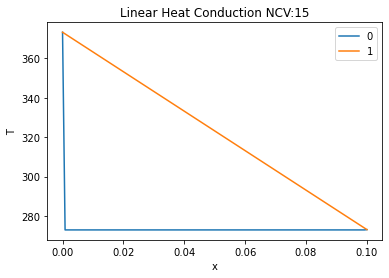

In [260]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.title("Linear Heat Conduction NCV:15")
plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

T_solns_1 = T_solns.copy()
grid1_xP = grid.xP

#print(grid.xP)
#print(T_solns_1)

In [261]:
#Problem 1 for a number of control volumes of 30

import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 30
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
k = 60

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 273

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 373.15, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 273.15, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))

Iteration = 0; Max. Resid. = 90.13499999999998; Avg. Resid. = 3.0089999999999986
Iteration = 1; Max. Resid. = 3.197442310920451e-14; Avg. Resid. = 1.295260195396016e-14


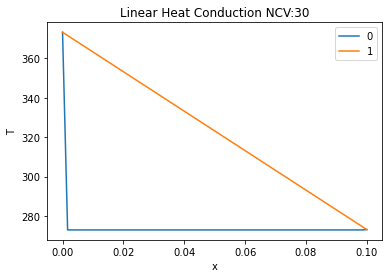

In [262]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.title("Linear Heat Conduction NCV:30")    
plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

T_solns_2 = T_solns.copy()
grid2_xP=grid.xP

In [251]:
#Problem 1 for a number of control volumes of 60

import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 60
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
k = 60

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 273

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 373.15, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 273.15, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))

Iteration = 0; Max. Resid. = 180.26999999999995; Avg. Resid. = 3.0089999999999986
Iteration = 1; Max. Resid. = 9.614531393253856e-14; Avg. Resid. = 2.903973358077868e-14


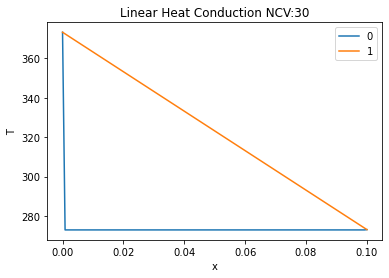

In [259]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    
    plt.plot(grid.xP, T, label=str(i))
    i += 1
plt.title("Linear Heat Conduction NCV:60")
plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

T_solns_3 = T_solns.copy()
grid3_xP=grid.xP

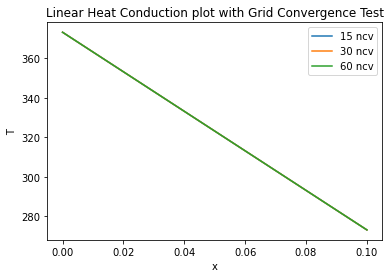

In [258]:
%matplotlib inline
import matplotlib.pyplot as plt

fig1, ax = plt.subplots()

ax.plot(grid1_xP, T_solns_1[-1], label="15 ncv")
ax.plot(grid2_xP, T_solns_2[-1], label="30 ncv")
ax.plot(grid3_xP, T_solns_3[-1], label="60 ncv")

ax.set_title("Linear Heat Conduction plot with Grid Convergence Test")
ax.set_xlabel("x")
ax.set_ylabel("T")
ax.legend()
plt.show()

## Analysis on the results for problem 1

Grid convergenge: The previous plot shows all the curves that the result of each calculation for the linear heat conduction through the bar. It possible to notice that all the curves are the same, since the result is similar for all the different number of control volume used. This provides information about the accuracy of the method used for this application as it provides a result that can satisty  the convergence and residuals requirements. 

Since all the grids provide the same result, the most optimal grid to use in this case will be the number of control volumes of 15, since is the coarsest, the number of calculations will be reduced as the grid is less without compromising the accuracy in the result. 

It is also noticeable that the residual changes one order og magnitud between the grid of 15 NCV and the ones with 30 and 60 NCV respectivelly. This does not affect the accuracy of the method in this case since it provides a residual that satisfy the requirements.

## Problem 2 - External Convection

Consider the same geometry and properties as in problem 1, except use $h$ = 12 [W/m$^2\cdot$K] for the exposed surfaces of the bar, and end temperatures of $T_1$ = $T_2$ = 100 [$^\circ$C].  Assume the surrounding air to be at $T_{\infty}$ = 25 [$^\circ$C]. Obtain the solution for this problem and compare your solution to the analytical solution.


## Solution External Convection
Using previous classes definitions, we will just add the Surface Convection Model and redefine the
new data to this external convection problem.
In this case beside using Dirichlet for the Boundary Conditions definition, it was used a convective heat source defined in the class of the SurfaceConvectionModel, where the source will be the effect of the convection in the bar since it is a one dimensional problem.

In [93]:
class SurfaceConvectionModel:
    """Class defining a surface convection model"""
    
    def __init__(self, grid, T, ho, To):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._ho = ho
        self._To = To
        
    def add(self, coeffs):
        """Function to add surface convection terms to coefficient arrays"""
        
        # Calculate the source term
        source = self._ho*self._grid.Ao*(self._T[1:-1] - self._To)
        
        # Calculate the linearization coefficients
        coeffP = self._ho*self._grid.Ao
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(source)
        
        return coeffs

In [263]:
#Problem 2 for a number of control values of 15

import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
k = 60

# Define convection parameters
ho = 12
To = 273.15+25

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 273

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 373, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 373, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = surfaceConvection.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    
    print(T_solns[-1])

Iteration = 0; Max. Resid. = 30.06036; Avg. Resid. = 6.0603599999999975
[373.         370.35687626 366.22593879 363.18421635 361.18304137
 360.19039505 360.19039505 361.18304137 363.18421635 366.22593879
 370.35687626 373.        ]
Iteration = 1; Max. Resid. = 1.5015766408055242e-14; Avg. Resid. = 9.43689570931383e-15


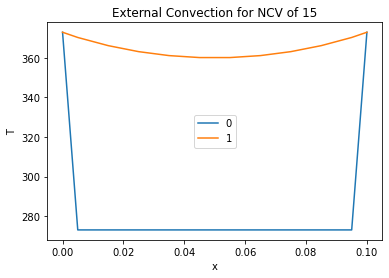

In [264]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.title("External Convection for NCV of 15")
plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

T_solns_1 = T_solns.copy()
grid1_xP=grid.xP

In [265]:
#Problem 2 for a number of control volumes of 30

import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 30
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
k = 60

# Define convection parameters
ho = 12
To = 273.15+25

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 273

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 373, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 373, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = surfaceConvection.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    
    print(T_solns[-1])

Iteration = 0; Max. Resid. = 90.02012000000018; Avg. Resid. = 6.020120000000007
[373.         372.11698922 370.48246454 368.9765309  367.59651109
 366.33995175 365.20461899 364.18849444 363.28977166 362.50685291
 361.83834635 361.28306352 360.84001725 360.50841989 360.28768195
 360.17741099 360.17741099 360.28768195 360.50841989 360.84001725
 361.28306352 361.83834635 362.50685291 363.28977166 364.18849444
 365.20461899 366.33995175 367.59651109 368.9765309  370.48246454
 372.11698922 373.        ]
Iteration = 1; Max. Resid. = 4.819755705653961e-14; Avg. Resid. = 2.0317312647103828e-14


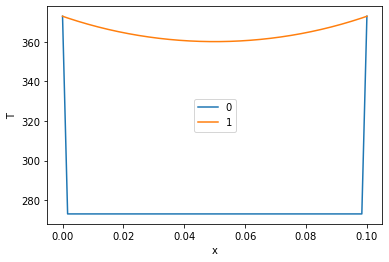

In [97]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.title("External Convection for NCV:30")
plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

T_solns_2 = T_solns.copy()
grid2_xP=grid.xP

In [98]:
#Problem 2 for a number of control volumes of 60

import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 60
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
k = 60

# Define convection parameters
ho = 12
To = 273.15+25

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 273

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 373, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 373, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = surfaceConvection.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    
    print(T_solns[-1])

Iteration = 0; Max. Resid. = 180.01006000000183; Avg. Resid. = 6.010060000000032
[373.         372.55840201 371.70827643 370.89084342 370.10573967
 369.35261625 368.63113844 367.94098557 367.28185093 366.65344155
 366.05547814 365.48769495 364.94983962 364.44167311 363.96296956
 363.51351623 363.09311334 362.70157406 362.33872437 362.004403
 361.69846137 361.4207635  361.17118596 360.94961784 360.75596067
 360.59012836 360.45204723 360.34165589 360.25890528 360.20375864
 360.17619144 360.17619144 360.20375864 360.25890528 360.34165589
 360.45204723 360.59012836 360.75596067 360.94961784 361.17118596
 361.4207635  361.69846137 362.004403   362.33872437 362.70157406
 363.09311334 363.51351623 363.96296956 364.44167311 364.94983962
 365.48769495 366.05547814 366.65344155 367.28185093 367.94098557
 368.63113844 369.35261625 370.10573967 370.89084342 371.70827643
 372.55840201 373.        ]
Iteration = 1; Max. Resid. = 8.619840952128754e-14; Avg. Resid. = 3.3378566114776004e-14


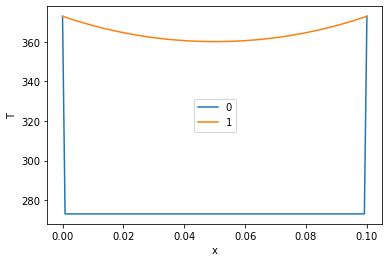

In [99]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

T_solns_3 = T_solns.copy()
grid3_xP=grid.xP

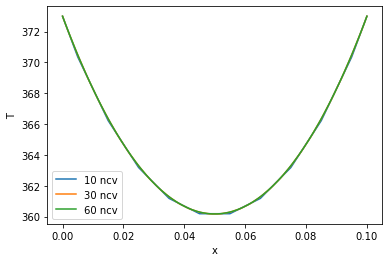

In [100]:
%matplotlib inline
import matplotlib.pyplot as plt

fig2, ax = plt.subplots()

ax.plot(grid1_xP, T_solns_1[-1], label="10 ncv")
ax.plot(grid2_xP, T_solns_2[-1], label="30 ncv")
ax.plot(grid3_xP, T_solns_3[-1], label="60 ncv")


ax.set_xlabel("x")
ax.set_ylabel("T")
ax.legend()
plt.show()

[373.15       372.28157393 370.64319622 369.1337144  367.75044454
 366.49092714 365.35292272 364.33440786 363.4335716  362.64881223
 361.97873439 361.42214667 360.97805944 360.64568308 360.42442662
 360.31389665 360.31389665 360.42442662 360.64568308 360.97805944
 361.42214667 361.97873439 362.64881223 363.4335716  364.33440786
 365.35292272 366.49092714 367.75044454 369.1337144  370.64319622
 372.28157393 373.15      ]


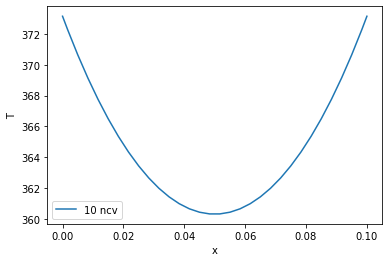

In [111]:
##ANALYTICAL SOLUTION

import math 

#Ambient Temperature

To = 273.15+25

#Temperature at the boundaries

Tl=373.15-To
Tb=373.15-To

#grid definition

grid_an = grid2_xP

#Parameters
P = (2*lz) + (2*ly)
Ac = lz*ly

#Calculation of m

m = math.sqrt((ho*P)/(k*Ac))

#Calculation of theta over thetab

c=(((Tl/Tb)*np.sinh(m*grid_an))+(np.sinh(m*(lx-grid_an))))/(np.sinh(m*lx))
#print(c)

T_an=(c*Tb)+To
print(T_an)

%matplotlib inline
import matplotlib.pyplot as plt

fig3, ax = plt.subplots()

ax.plot(grid_an, T_an, label="10 ncv")

ax.set_xlabel("x")
ax.set_ylabel("T")
ax.legend()
plt.show()




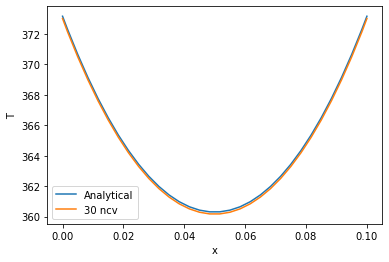

In [112]:
fig4, ax = plt.subplots()

ax.plot(grid_an, T_an, label="Analytical")
ax.plot(grid2_xP, T_solns_2[-1], label="30 ncv")



ax.set_xlabel("x")
ax.set_ylabel("T")
ax.legend()
plt.show()

## Problem 3 - Internal Heat Generation

A plane wall $L$ = 0.1 [m] thick with a thermal conductivity of $k$ = 26 [W/m$\cdot$K] is exposed to an environment at an ambient temperature of 50 [$^\circ$C] on one side and an environment of 40 [$^\circ$C] on the other side. The convection coefficient at the exposed surfaces is estimated to be $h$ = 280 [W/m$^2\cdot$K]. If heat is generated uniformly within the wall at a rate 50,000 [W/m$^3$], determine the surface temperatures of the walls, and the location and value of the maximum temperature inside the wall. Compare your result to the analytical result, which can be obtained from a heat transfer textbook.

In [242]:
##Using the same previous classes defined, in this case considering the set up of the boundary conditions
# and the conditions of the source, the following classes are developed:

class RobinBc:
    """Class defining a Neumann boundary condition"""
   
    def __init__(self, phi, grid, h, k, To, loc):
        """Constructor
            phi ........ field variable array
            grid ....... grid
            h........... convection coefficient
            k........... thermal conductivity
            Tamb........ ambient temperature
            loc ........ boundary location
        """
        self._phi = phi
        self._grid = grid
        self._h = h
        self._k = k
        self._To = To
        self._loc = loc
       
    def value(self):
        """Return the boundary condition value"""
        if self._loc is BoundaryLocation.WEST:
            return (self._phi[1] + ((self._h/self._k)*self._grid.dx_WP[0]* self._To))/(1+((self._h/self._k)*self._grid.dx_WP[0]))
        elif self._loc is BoundaryLocation.EAST:
            return (self._phi[-2] + ((self._h/self._k)*self._grid.dx_PE[-1]* self._To))/(1+((self._h/self._k)*self._grid.dx_PE[-1]))
        else:
            raise ValueError("Unknown boundary location")
   
    def coeff(self):
        """Return the linearization coefficient"""
        if self._loc is BoundaryLocation.WEST:
            return (1/(1+((self._h/self._k)*self._grid.dx_WP[0])))
        elif self._loc is BoundaryLocation.EAST:
            return (1/(1+((self._h/self._k)*self._grid.dx_PE[-1])))
     
    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = (self._phi[1] + ((self._h/self._k)*self._grid.dx_WP[0]* self._To))/(1+((self._h/self._k)*self._grid.dx_WP[0]))
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = (self._phi[-2] + ((self._h/self._k)*self._grid.dx_PE[-1]* self._To))/(1+((self._h/self._k)*self._grid.dx_PE[-1]))
        else:
            raise ValueError("Unknown boundary location")
            

In [243]:
class InternalConvection:
    """Class defining a surface convection model"""
    
    def __init__(self, grid, qo):
        
        """Constructor"""
        self._grid = grid
        self._qo = qo
        
    def add(self, coeffs):
        """Function to add surface convection terms to coefficient arrays"""
        
        # Calculate the source term
        source =  qo*self._grid.vol
        
        # Calculate the linearization coefficients
        coeffP = 0
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(-source)
        
        return coeffs
    

In [244]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 100
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
k = 26

# Define convection parameters
ho = 280

#Ambient temperatures
T1=323
T2=313

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 323

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = RobinBc(T, grid, ho, k, T1, BoundaryLocation.WEST) #self, phi, grid, h, k, Tamb, loc
east_bc = RobinBc(T, grid, ho, k, T2, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model with internal source
qo=50000
Internal = InternalConvection(grid, qo)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = Internal.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    
    print(T_solns[-1])

Iteration = 0; Max. Resid. = 0.0683750956388098; Avg. Resid. = 0.0019212509563880978
[328.67857143 328.70914835 328.76837912 328.82568681 328.88107143
 328.93453297 328.98607143 329.03568681 329.08337912 329.12914835
 329.17299451 329.21491758 329.25491758 329.29299451 329.32914835
 329.36337912 329.39568681 329.42607143 329.45453297 329.48107143
 329.50568681 329.52837912 329.54914835 329.56799451 329.58491758
 329.59991758 329.61299451 329.62414835 329.63337912 329.64068681
 329.64607143 329.64953297 329.65107143 329.65068681 329.64837912
 329.64414835 329.63799451 329.62991758 329.61991758 329.60799451
 329.59414835 329.57837912 329.56068681 329.54107143 329.51953297
 329.49607143 329.47068681 329.44337912 329.41414835 329.38299451
 329.34991758 329.31491758 329.27799451 329.23914835 329.19837912
 329.15568681 329.11107143 329.06453297 329.01607143 328.96568681
 328.91337912 328.85914835 328.80299451 328.74491758 328.68491758
 328.62299451 328.55914835 328.49337912 328.42568681 328.

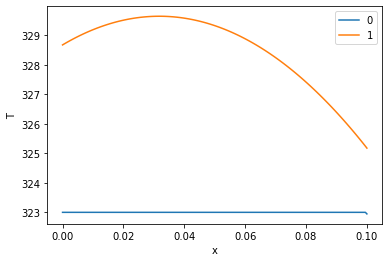

In [241]:
##POST PROCESSING

%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

## Problem 4 - Radiation 

Solve the following problem using the square bar geometry given in question 1 with $T_\infty$ = 0 [K]. Assume that the convection coefficient is $h$ = 0 [W/m$^2\cdot$K], the emmisivity is $\epsilon$ = 1.0, the end temperatures are $T_1$ = 400 [K] and $T_2$ = 0 [K]. Try solving this problem using the following linearizations of the radiation source term:

- Apply $q_o^{\prime\prime} = \epsilon \sigma (T^4 - T_\infty^4)$ into the residual and do not include any contribution from this term into the Jacobian matrix. This is an explicit implementation of the source term.
- Apply $q_o^{\prime\prime} = \epsilon \sigma (T^4 - T_\infty^4)$ into the residual and include the linearizaton $\partial q_o^{\prime\prime}/\partial T$ into the Jacobian matrix. This is an implicit implementation of the source term.

Solve using each linearization assuming the material is:

- Steel, for which: $k$ = 60 [W/m$\cdot$K], $c_p$ = 430 [J/kg$\cdot$K]
- Wood, for which: $k$ = 0.1 [W/m$\cdot$K], $c_p$ = 1.3 [J/kg$\cdot$K]

Explain any differences that you observe.

In [146]:


class SurfaceRadiationModelExplicit:
    """Class defining a surface convection model"""
    
    def __init__(self, grid, T, Ep, Sig, To):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._Ep = Ep
        self._Sig = Sig
        self._To = To
        
    def add(self, coeffs):
        """Function to add surface convection terms to coefficient arrays"""
        
        # Calculate the source term
        source = grid.Ao*self._Ep*self._Sig*(((self._T[1:-1])**4) - ((self._To)**4))
        
        # Calculate the linearization coefficients
        coeffP = 0
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(source)
        
        return coeffs

In [147]:
class SurfaceRadiationModelImplicit:
    """Class defining a surface convection model"""
    
    def __init__(self, grid, T, Ep, Sig, To):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._Ep = Ep
        self._Sig = Sig
        self._To = To
        
    def add(self, coeffs):
        """Function to add surface convection terms to coefficient arrays"""
        
        # Calculate the source term
        source = (grid.Ao*self._Ep*self._Sig*(((self._T[1:-1])**4) - ((self._To)**4)))
        
        # Calculate the linearization coefficients
        coeffP = (self._Ep*self._Sig*3*grid.Ao)*((self._T[1:-1])**3)
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(source)
        
        return coeffs

In [148]:
## EXPLICIT METHOD FOR STEEL FOR A NUMBER OF CONTROL VALUES OF 10

import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 200
converged = 1e-6

# Define thermophysical properties
k = 60

# Define radiation parameters
Ep=1
Sig=(5.67)*(10e-8)
To=0

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 300

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)


# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model with internal source
RadiationEx = SurfaceRadiationModelExplicit(grid, T, Ep, Sig, To) #grid, T, Ep, Sig, To

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = RadiationEx.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T)) 
    
    

Iteration = 0; Max. Resid. = 900.0918539999992; Avg. Resid. = 12.090016919999993
Iteration = 1; Max. Resid. = 0.18833458263904457; Avg. Resid. = 0.08055372056120012
Iteration = 2; Max. Resid. = 0.03312176580945286; Avg. Resid. = 0.01263989845033179
Iteration = 3; Max. Resid. = 0.012095078643212326; Avg. Resid. = 0.004364307799755925
Iteration = 4; Max. Resid. = 0.004023669666932045; Avg. Resid. = 0.0014060143028396485
Iteration = 5; Max. Resid. = 0.0013057351170841919; Avg. Resid. = 0.0004541202306247659
Iteration = 6; Max. Resid. = 0.00042044100845603505; Avg. Resid. = 0.00014594024690574772
Iteration = 7; Max. Resid. = 0.00013522496309507914; Avg. Resid. = 4.69316302843138e-05
Iteration = 8; Max. Resid. = 4.3472745489742115e-05; Avg. Resid. = 1.5085936816494056e-05
Iteration = 9; Max. Resid. = 1.3975307705318962e-05; Avg. Resid. = 4.8497307029996735e-06
Iteration = 10; Max. Resid. = 4.492557689791954e-06; Avg. Resid. = 1.5589995797821169e-06
Iteration = 11; Max. Resid. = 1.4441955562

In [ ]:
## EXPLICIT METHOD FOR STEEL FOR A NUMBER OF CONTROL VALUES OF 40

import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 40
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 200
converged = 1e-6

# Define thermophysical properties
k = 60

# Define radiation parameters
Ep=1
Sig=(5.67)*(10e-8)
To=0

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 300

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)


# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model with internal source
RadiationEx = SurfaceRadiationModelExplicit(grid, T, Ep, Sig, To) #grid, T, Ep, Sig, To

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = RadiationEx.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T)) 
    
    

In [151]:
## EXPLICIT METHOD FOR STEEL FOR A NUMBER OF CONTROL VALUES OF 10

import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 70
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 200
converged = 1e-6

# Define thermophysical properties
k = 60

# Define radiation parameters
Ep=1
Sig=(5.67)*(10e-8)
To=0

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 300

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)


# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model with internal source
RadiationEx = SurfaceRadiationModelExplicit(grid, T, Ep, Sig, To) #grid, T, Ep, Sig, To

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = RadiationEx.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T)) 
    
    

Iteration = 0; Max. Resid. = 630.1312199999925; Avg. Resid. = 12.127470857142752
Iteration = 1; Max. Resid. = 0.2629733100582657; Avg. Resid. = 0.11504046760332101
Iteration = 2; Max. Resid. = 0.04731780740845548; Avg. Resid. = 0.018053391738173028
Iteration = 3; Max. Resid. = 0.017275647493091156; Avg. Resid. = 0.006235482109181885
Iteration = 4; Max. Resid. = 0.005743367613742667; Avg. Resid. = 0.0020091131995194247
Iteration = 5; Max. Resid. = 0.0018640040413304138; Avg. Resid. = 0.0006489804240256096
Iteration = 6; Max. Resid. = 0.0006003570195730612; Avg. Resid. = 0.00020858309894954873
Iteration = 7; Max. Resid. = 0.00019311082106915345; Avg. Resid. = 6.7082941156444e-05
Iteration = 8; Max. Resid. = 6.20888707140721e-05; Avg. Resid. = 2.156557071457192e-05
Iteration = 9; Max. Resid. = 1.9961812713270577e-05; Avg. Resid. = 6.933435214376015e-06
Iteration = 10; Max. Resid. = 6.417631559590964e-06; Avg. Resid. = 2.229045781506843e-06
Iteration = 11; Max. Resid. = 2.0632375648810264e

In [164]:
## IMPLICIT METHOD FOR STEEL USING NCV OF 10

import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 300
converged = 1e-6

# Define thermophysical properties
k = 60

# Define radiation parameters
Ep=1
Sig=5.67*(10e-8)
To=0

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 300

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)


# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model with internal source
RadiationIm = SurfaceRadiationModelImplicit(grid, T, Ep, Sig, To) #grid, T, Ep, Sig, To

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = RadiationIm.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    
    #print(T_solns[-1])

Iteration = 0; Max. Resid. = 90.91853999999992; Avg. Resid. = 12.734831999999992
Iteration = 1; Max. Resid. = 1.5698162787441172; Avg. Resid. = 0.509252724639849
Iteration = 2; Max. Resid. = 0.02433736024910238; Avg. Resid. = 0.010015685175072613
Iteration = 3; Max. Resid. = 0.0017713813522539645; Avg. Resid. = 0.000638490659569331
Iteration = 4; Max. Resid. = 0.00011797785643219427; Avg. Resid. = 4.1725599937163104e-05
Iteration = 5; Max. Resid. = 7.739124036065803e-06; Avg. Resid. = 2.7275718269693674e-06
Iteration = 6; Max. Resid. = 5.061301067144086e-07; Avg. Resid. = 1.782476931590103e-07


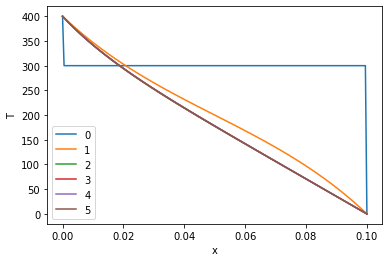

In [171]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

T_solns_1 = T_solns[-1]
grid1_xP=grid.xP

In [172]:
## IMPLICIT METHOD FOR STEEL USING NCV OF 50

import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 50
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 300
converged = 1e-6

# Define thermophysical properties
k = 60

# Define radiation parameters
Ep=1
Sig=5.67*(10e-8)
To=0

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 300

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)


# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model with internal source
RadiationIm = SurfaceRadiationModelImplicit(grid, T, Ep, Sig, To) #grid, T, Ep, Sig, To

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = RadiationIm.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    
    #print(T_solns[-1])

Iteration = 0; Max. Resid. = 450.1837079999996; Avg. Resid. = 12.176359679999992
Iteration = 1; Max. Resid. = 0.35665500132265254; Avg. Resid. = 0.10398653668699233
Iteration = 2; Max. Resid. = 0.004834270248105094; Avg. Resid. = 0.0019270338902843877
Iteration = 3; Max. Resid. = 0.00034634186639428965; Avg. Resid. = 0.0001227398407827651
Iteration = 4; Max. Resid. = 2.2846567594964062e-05; Avg. Resid. = 7.970709137692523e-06
Iteration = 5; Max. Resid. = 1.485761937092267e-06; Avg. Resid. = 5.167170828923509e-07
Iteration = 6; Max. Resid. = 9.632685452065637e-08; Avg. Resid. = 3.3474979779366844e-08


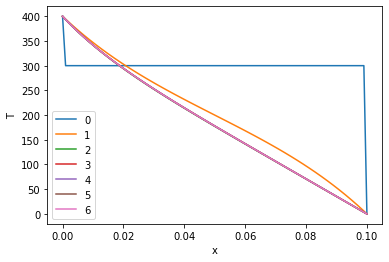

In [173]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

T_solns_2 = T_solns[-1]
grid2_xP=grid.xP

In [174]:
## IMPLICIT METHOD FOR STEEL USING NCV OF 100

import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 100
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 300
converged = 1e-6

# Define thermophysical properties
k = 60

# Define radiation parameters
Ep=1
Sig=5.67*(10e-8)
To=0

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 300

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)


# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model with internal source
RadiationIm = SurfaceRadiationModelImplicit(grid, T, Ep, Sig, To) #grid, T, Ep, Sig, To

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = RadiationIm.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    
    #print(T_solns[-1])

Iteration = 0; Max. Resid. = 900.0918539999992; Avg. Resid. = 12.090016919999993
Iteration = 1; Max. Resid. = 0.18101721330479742; Avg. Resid. = 0.05203021867774133
Iteration = 2; Max. Resid. = 0.0024164492463178006; Avg. Resid. = 0.000961776283138709
Iteration = 3; Max. Resid. = 0.00017329561419364425; Avg. Resid. = 6.1300848573276e-05
Iteration = 4; Max. Resid. = 1.142441257627469e-05; Avg. Resid. = 3.98021091233787e-06
Iteration = 5; Max. Resid. = 7.426719870751164e-07; Avg. Resid. = 2.579680263791781e-07


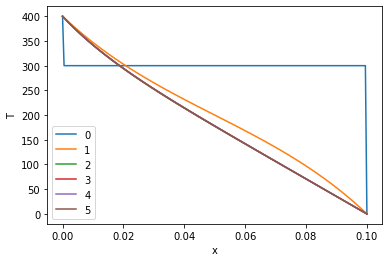

In [175]:
%matplotlib inline
import matplotlib.pyplot as plt

#plt.figure(figsize=(7,7))

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1


plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

T_solns_3 = T_solns[-1]
grid3_xP=grid.xP

ValueError: x and y must have same first dimension, but have shapes (102,) and (1,)

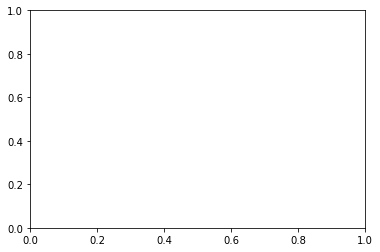

In [176]:
%matplotlib inline
import matplotlib.pyplot as plt

fig2, ax = plt.subplots()

ax.plot(grid1_xP, T_solns_1[-1], label="10 ncv")
ax.plot(grid2_xP, T_solns_2[-1], label="30 ncv")
ax.plot(grid3_xP, T_solns_3[-1], label="60 ncv")


ax.set_xlabel("x")
ax.set_ylabel("T")
ax.legend()
plt.show()

In [ ]:
USING WOOD AS MATERIAL

In [158]:
## EXPLICIT METHOD FOR STEEL FOR A NUMBER OF CONTROL VALUES OF 10

import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 50
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 200
converged = 1e-6

# Define thermophysical properties
k = 0.1

# Define radiation parameters
Ep=1
Sig=(5.67)*(10e-8)
To=0

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 300

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)


# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model with internal source
RadiationEx = SurfaceRadiationModelExplicit(grid, T, Ep, Sig, To) #grid, T, Ep, Sig, To

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = RadiationEx.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T)) 

Iteration = 0; Max. Resid. = 0.9337079999999993; Avg. Resid. = 0.19635967999999995
Iteration = 1; Max. Resid. = 99194100.19674183; Avg. Resid. = 40279114.47972903
Iteration = 2; Max. Resid. = 1.207778980906578e+42; Avg. Resid. = 4.0930563137983286e+41
Iteration = 3; Max. Resid. = 1.5394036145284168e+178; Avg. Resid. = 4.99031988415923e+177
Iteration = 4; Max. Resid. = inf; Avg. Resid. = inf
Iteration = 5; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 6; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 7; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 8; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 9; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 10; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 11; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 12; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 13; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 14; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 15; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 16; Max. Resid. 

<ipython-input-146-064339902e27>:16: RuntimeWarning: overflow encountered in power
  source = grid.Ao*self._Ep*self._Sig*(((self._T[1:-1])**4) - ((self._To)**4))


Iteration = 179; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 180; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 181; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 182; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 183; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 184; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 185; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 186; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 187; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 188; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 189; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 190; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 191; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 192; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 193; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 194; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 195; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 196; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 197; Max. Resid.

In [159]:
## IMPLICIT METHOD FOR WOOD USING NCV OF 50

import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 50
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 300
converged = 1e-6

# Define thermophysical properties
k = 0.1

# Define radiation parameters
Ep=1
Sig=5.67*(10e-8)
To=0

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 300

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)


# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model with internal source
RadiationIm = SurfaceRadiationModelImplicit(grid, T, Ep, Sig, To) #grid, T, Ep, Sig, To

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = RadiationIm.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    
    #print(T_solns[-1])

Iteration = 0; Max. Resid. = 0.9337079999999993; Avg. Resid. = 0.19635967999999995
Iteration = 1; Max. Resid. = 0.17958331881283582; Avg. Resid. = 0.03869667557071384
Iteration = 2; Max. Resid. = 0.016901410488613534; Avg. Resid. = 0.007170284425279585
Iteration = 3; Max. Resid. = 0.003110793395873233; Avg. Resid. = 0.001325316025482183
Iteration = 4; Max. Resid. = 0.0005946533770490092; Avg. Resid. = 0.00023493810113547239
Iteration = 5; Max. Resid. = 8.596514169544648e-05; Avg. Resid. = 3.0141027345885347e-05
Iteration = 6; Max. Resid. = 4.691802777155921e-06; Avg. Resid. = 1.5459238059760278e-06
Iteration = 7; Max. Resid. = 9.968192743899356e-07; Avg. Resid. = 4.135066906791604e-07


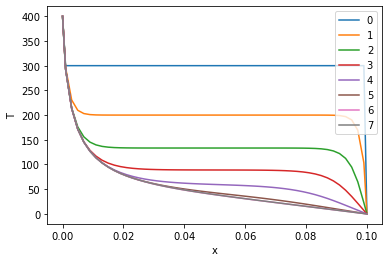

In [160]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

#T_solns_2 = T_solns.copy()
#grid2_xP=grid.xP